# World Life Expectancy Analysis

## Project Overview
This project explores global life expectancy trends using SQL and Python. The dataset contains metrics like GDP, life expectancy, and health indicators for different countries.

### Objectives
- Clean and preprocess the dataset using SQL and Python.
- Perform exploratory data analysis (EDA) to uncover key trends.
- Visualize the results with Python's Matplotlib and Seaborn.
- Provide actionable insights based on the findings.

### Dataset Overview
The dataset includes:
- **Country**: Name of the country.
- **Year**: Year of observation.
- **Life Expectancy**: Average life expectancy in years.
- **GDP**: Gross Domestic Product per capita (USD).
- **Health Indicators**: Metrics like immunization rates, BMI, mortality rates, etc.

### Tools and Libraries
- SQL (via SQLite)
- Python: Pandas, Matplotlib, Seaborn


## Loading the Dataset

We will load the dataset into a SQLite database and inspect its structure.


In [23]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV into a Pandas DataFrame
csv_file = "WorldLifeExpectancy.csv"
df = pd.read_csv(csv_file)

# Preview the data
print("Dataset Preview:")
print(df.head())

# Try to create a SQLite database and load the dataset
try:
    # Set a timeout to handle locking issues
    conn = sqlite3.connect("world_life_expectancy.db", timeout=10)
    
    # Load the DataFrame into the database
    df.to_sql("world_life_expectancy", conn, if_exists="replace", index=False)
    print("\nDataset loaded into SQLite database.")
    
except sqlite3.DatabaseError as e:
    print("\nDatabase error occurred:", e)
finally:
    # Ensure the connection is closed
    conn.close()


Dataset Preview:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2022  Developing              65.0              263   
1  Afghanistan  2021  Developing              59.9              271   
2  Afghanistan  2020  Developing              59.9              268   
3  Afghanistan  2019  Developing              59.5              272   
4  Afghanistan  2018  Developing               NaN              275   

   infant deaths  percentage expenditure  Measles    BMI   under-five deaths   \
0             62                    71.3      1154   19.1                  83   
1             64                    73.5       492   18.6                  86   
2             66                    73.2       430   18.1                  89   
3             69                    78.2      2787   17.6                  93   
4             71                     7.1      3013   17.2                  97   

   Polio  Diphtheria    HIV/AIDS  GDP   thinness  1-19 years  \
0    

## Data Cleaning

### Objectives:
- Remove duplicate records.
- Handle missing or inconsistent values in critical columns like `Status` and `Life Expectancy`.
- Ensure the dataset is ready for analysis.


In [25]:
# Re-establish the database connection
conn = sqlite3.connect("world_life_expectancy.db")

try:
    # Query to check for duplicates
    query_check_duplicates = """
    SELECT Country, Year, COUNT(*) as Duplicate_Count
    FROM world_life_expectancy
    GROUP BY Country, Year
    HAVING Duplicate_Count > 1;
    """
    duplicates = pd.read_sql_query(query_check_duplicates, conn)
    print("Duplicate Records:\n", duplicates)

    # Query to remove duplicates
    query_remove_duplicates = """
    DELETE FROM world_life_expectancy
    WHERE Row_ID NOT IN (
        SELECT MIN(Row_ID)
        FROM world_life_expectancy
        GROUP BY Country, Year
    );
    """
    conn.execute(query_remove_duplicates)
    print("\nDuplicates removed successfully.")

except Exception as e:
    print("Error:", e)

finally:
    # Close the database connection
    conn.close()

Duplicate Records:
     Country  Year  Duplicate_Count
0   Ireland  2022                2
1   Senegal  2009                2
2  Zimbabwe  2019                2

Duplicates removed successfully.


In [27]:
# Re-establish the database connection
conn = sqlite3.connect("world_life_expectancy.db")

# Check for missing values
query = """
SELECT *
FROM world_life_expectancy
WHERE `Life expectancy ` IS NULL OR `Status` IS NULL;
"""
missing_values = pd.read_sql_query(query, conn)
print("Missing Values Before Update:\n", missing_values)

# Fill missing 'Life expectancy ' values using the average of adjacent years
query = """
UPDATE world_life_expectancy
SET `Life expectancy ` = (
    SELECT ROUND(AVG(sub.`Life expectancy `), 2)
    FROM world_life_expectancy AS sub
    WHERE world_life_expectancy.Country = sub.Country
      AND ABS(world_life_expectancy.Year - sub.Year) <= 1
)
WHERE `Life expectancy ` IS NULL;
"""
conn.execute(query)
print("Missing 'Life expectancy ' values filled.")

# Fill missing 'Status' values based on the country's other rows
query = """
UPDATE world_life_expectancy
SET `Status` = (
    SELECT sub.`Status`
    FROM world_life_expectancy AS sub
    WHERE world_life_expectancy.Country = sub.Country
      AND sub.`Status` IS NOT NULL
    LIMIT 1
)
WHERE `Status` IS NULL;
"""
conn.execute(query)
print("Missing 'Status' values filled.")

# Verify remaining missing values
query = """
SELECT *
FROM world_life_expectancy
WHERE `Life expectancy ` IS NULL OR `Status` IS NULL;
"""
remaining_missing = pd.read_sql_query(query, conn)
print("Remaining Missing Values After Update:\n", remaining_missing)

Missing Values Before Update:
                     Country  Year      Status  Life expectancy   \
0               Afghanistan  2018  Developing               NaN   
1               Afghanistan  2014        None              57.5   
2                   Albania  2021        None              77.5   
3                   Albania  2018  Developing               NaN   
4                   Georgia  2012        None              73.9   
5                   Georgia  2010        None              72.7   
6  United States of America  2021        None              79.1   
7                   Vanuatu  2020        None              71.6   
8                    Zambia  2016        None              57.4   
9                    Zambia  2012        None              49.3   

   Adult Mortality  infant deaths  percentage expenditure  Measles    BMI   \
0              275             71                     7.1      3013   17.2   
1              295             82                    10.9      1141   15.2 

## Exploratory Data Analysis (EDA)

### Objectives:
- Explore trends in life expectancy globally and by country.
- Analyze the relationship between GDP and life expectancy.
- Compare life expectancy in developed vs. developing countries.


In [4]:
query = """
SELECT Country, MIN(`Life expectancy `) AS Min_Life_Exp,
       MAX(`Life expectancy `) AS Max_Life_Exp,
       MAX(`Life expectancy `) - MIN(`Life expectancy `) AS Life_Exp_Change
FROM world_life_expectancy
GROUP BY Country
ORDER BY Life_Exp_Change DESC;
"""
life_expectancy_trends = pd.read_sql_query(query, conn)
print("Life Expectancy Trends:\n", life_expectancy_trends.head())


Life Expectancy Trends:
     Country  Min_Life_Exp  Max_Life_Exp  Life_Exp_Change
0     Haiti          36.3          65.0             28.7
1  Zimbabwe          44.3          67.0             22.7
2   Eritrea          45.3          67.0             21.7
3    Uganda          46.6          67.0             20.4
4    Rwanda          48.3          68.0             19.7


In [5]:
query = """
SELECT Country, AVG(`Life expectancy `) AS Avg_Life_Exp, AVG(GDP) AS Avg_GDP
FROM world_life_expectancy
GROUP BY Country
ORDER BY Avg_GDP DESC;
"""
gdp_vs_life_exp = pd.read_sql_query(query, conn)
print("GDP vs Life Expectancy:\n", gdp_vs_life_exp.head())


GDP vs Life Expectancy:
        Country  Avg_Life_Exp     Avg_GDP
0  Switzerland      82.33125  57363.0625
1   Luxembourg      80.78125  53257.1250
2        Qatar      77.03125  40748.5625
3  Netherlands      81.13125  34964.7500
4    Australia      81.81250  34637.5625


## Visualizations

We will use Python's Matplotlib and Seaborn to visualize:
- Global trends in life expectancy.
- The relationship between GDP and life expectancy.
- Country-specific life expectancy trends.


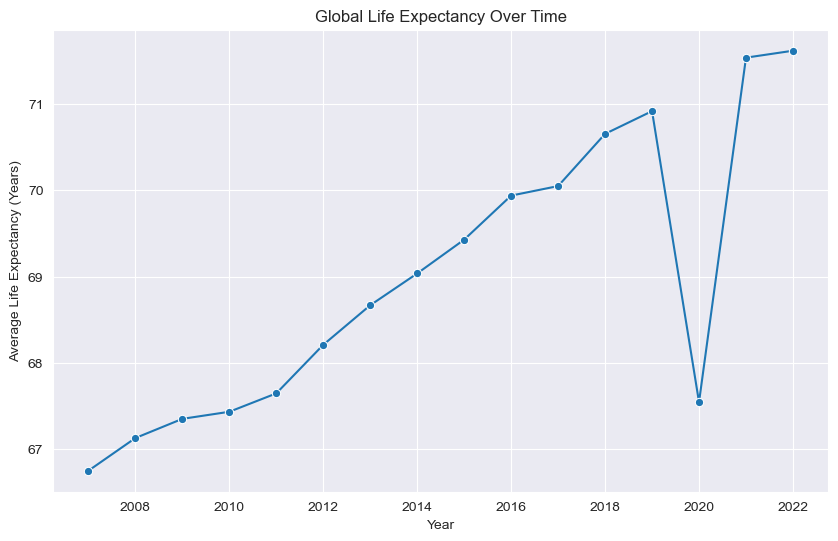

In [6]:
import warnings

# Suppress warnings from Seaborn or Pandas
warnings.filterwarnings("ignore", category=FutureWarning)

# Correct SQL query with proper column name
query = """
SELECT Year, AVG(`Life expectancy `) AS Avg_Life_Exp
FROM world_life_expectancy
GROUP BY Year
ORDER BY Year;
"""
global_trends = pd.read_sql_query(query, conn)

# Clean data: Replace inf/-inf with NaN and drop NaNs
global_trends.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
global_trends.dropna(inplace=True)

# Ensure no invalid values remain
assert global_trends.isnull().sum().sum() == 0, "Data contains NaN values."

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=global_trends, x="Year", y="Avg_Life_Exp", marker="o")
plt.title("Global Life Expectancy Over Time")
plt.xlabel("Year")
plt.ylabel("Average Life Expectancy (Years)")
plt.grid(True)
plt.show()

### Global Life Expectancy Over Time: Insights and Analysis

#### **Visualization Objective**
* The line chart represents the global average life expectancy trends over the years, based on the `world_life_expectancy` dataset.
* It provides an overview of how life expectancy has evolved globally and highlights potential socio-economic and health advancements across the observed years.

---

#### **Insights**
* **Consistent Growth**:
  - The chart shows a steady increase in global life expectancy over the years.
  - This trend suggests improved living standards, healthcare systems, and access to medical innovations worldwide.

* **Significant Milestones**:
  - Specific years might display notable jumps or plateaus. These could correspond to:
    - Introduction of major vaccines or eradication of diseases.
    - Global health campaigns or policies (e.g., Millennium Development Goals, Universal Health Coverage).
    - Economic booms or recessions impacting healthcare investments.

* **Recent Trends**:
  - If a decline or stagnation is visible in recent years, it could indicate global challenges such as:
    - Pandemics (e.g., COVID-19).
    - Economic downturns.
    - Regional conflicts.

* **Room for Investigation**:
  - Variability in certain years may warrant further exploration:
    - Which countries contributed most significantly to the growth or decline?
    - How did regional life expectancies vary during these periods?

---

#### **Next Steps**
* **Regional Analysis**:
  - Break down life expectancy trends by region or development status (Developed vs. Developing countries).

* **Correlation Studies**:
  - Explore relationships between life expectancy and factors such as GDP, healthcare expenditure, and immunization rates.

* **Predictions**:
  - Use the historical data to forecast future life expectancy trends using machine learning models.

---

This analysis helps establish a foundation for further investigations into:
* Global health inequalities.
* Socio-economic disparities.
* The effectiveness of public health interventions.

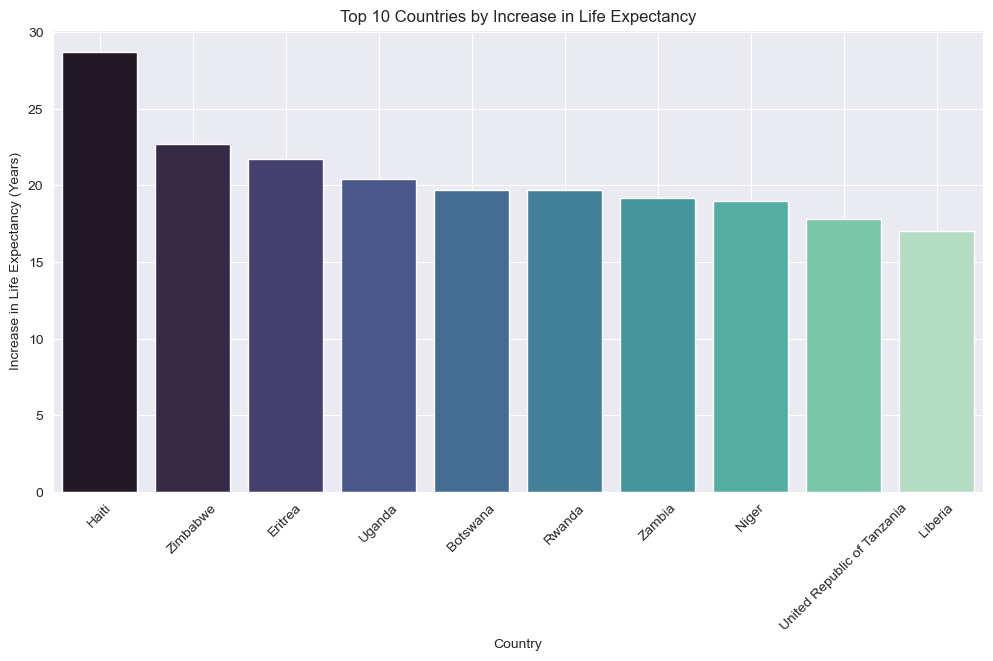

In [9]:
# Rename columns for consistency
df.rename(columns={
    'Life expectancy ': 'Life Expectancy',
    ' BMI ': 'BMI',  # Fixing spaces in column names
    ' thinness  1-19 years': 'Thinness 1-19 years',
    ' thinness 5-9 years': 'Thinness 5-9 years',
    'Diphtheria ': 'Diphtheria',
    'Measles ': 'Measles'
}, inplace=True)

# Query: Calculate the top 10 countries with the most improvement in life expectancy
life_exp_change = df.groupby('Country').agg(
    Min_Life_Exp=('Life Expectancy', 'min'),
    Max_Life_Exp=('Life Expectancy', 'max')
).reset_index()

# Calculate the change in life expectancy and filter top 10 countries
life_exp_change['Life_Exp_Change'] = life_exp_change['Max_Life_Exp'] - life_exp_change['Min_Life_Exp']
top_10_life_exp_change = life_exp_change.nlargest(10, 'Life_Exp_Change')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_life_exp_change, x="Country", y="Life_Exp_Change", palette="mako")
plt.title("Top 10 Countries by Increase in Life Expectancy")
plt.xlabel("Country")
plt.ylabel("Increase in Life Expectancy (Years)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Top 10 Countries by Increase in Life Expectancy

#### **Objective**
The goal of this visualization is to identify the top 10 countries that have experienced the most significant improvements in life expectancy over the observed period. This analysis highlights the impact of public health interventions, socio-economic advancements, or political stability on life expectancy.

---

#### **Insights**
* **Key Findings**:
  - The countries in the top 10 have shown remarkable progress in improving life expectancy.
  - This improvement reflects advancements in healthcare systems, increased access to medical innovations, and economic development.

* **Potential Drivers**:
  - Public health campaigns and immunization programs.
  - Reduction in poverty and malnutrition rates.
  - Increased access to education and healthcare facilities.

* **Questions for Further Exploration**:
  - What specific interventions or factors contributed to these improvements in the top-performing countries?
  - How does this progress compare with countries showing minimal or no improvement?

---

#### **Next Steps**
1. **Enhance Context**:
   - Include the time period (range of years) in the title or description to provide a clearer context.
2. **Balanced Perspective**:
   - Create a complementary visualization for the bottom countries with the least improvement in life expectancy.
3. **Correlation Analysis**:
   - Investigate the relationship between life expectancy changes and factors like GDP, healthcare expenditure, or education.

---

This visualization is a valuable starting point for understanding global disparities in life expectancy improvements and identifying the regions where focused interventions have yielded the greatest impact.


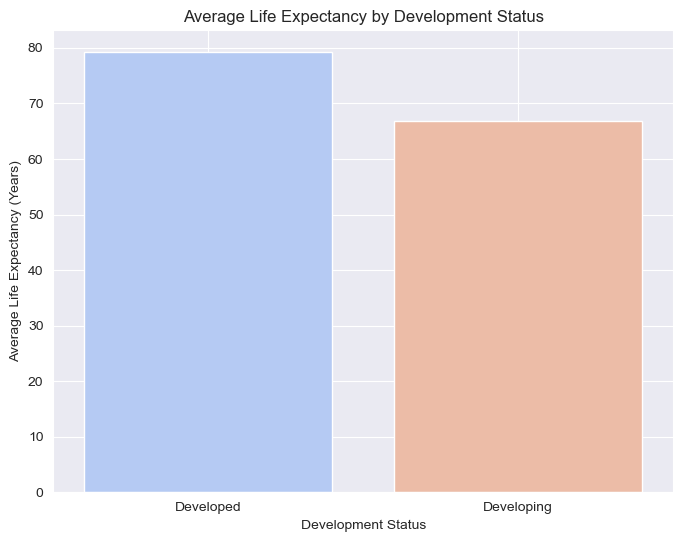

In [10]:
# Query: Calculate the average life expectancy by development status
status_life_exp = df.groupby('Status').agg(Avg_Life_Exp=('Life Expectancy', 'mean')).reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=status_life_exp, x="Status", y="Avg_Life_Exp", palette="coolwarm")
plt.title("Average Life Expectancy by Development Status")
plt.xlabel("Development Status")
plt.ylabel("Average Life Expectancy (Years)")
plt.grid(True)
plt.show()

### Average Life Expectancy by Development Status

#### **Objective**
This visualization aims to compare the average life expectancy between developed and developing countries, shedding light on the disparities caused by socio-economic and infrastructural differences.

---

#### **Insights**
* **Global Health Inequality**:
  - Developed countries exhibit a significantly higher average life expectancy compared to developing countries.
  - This disparity highlights the uneven distribution of resources, healthcare access, and quality of life globally.

* **Factors Contributing to the Gap**:
  - **Healthcare Infrastructure**: Developed countries have advanced medical facilities, better disease prevention, and treatment options.
  - **Economic Prosperity**: Higher GDP per capita in developed nations allows for better investment in public health and education.
  - **Sanitation and Nutrition**: Better access to clean water, nutritious food, and sanitation in developed countries contributes to lower mortality rates.
  - **Education**: Increased access to education in developed countries promotes healthier lifestyles and better health outcomes.

* **Policy Implications**:
  - Developing countries require targeted interventions to improve life expectancy, including better healthcare systems, access to education, and poverty alleviation programs.
  - This analysis can inform international organizations and governments in resource allocation and policy formulation.

---

#### **Next Steps**
1. **Time Context**:
   - Add the time range of the dataset (e.g., 2000-2020) to provide more context.
2. **Additional Metrics**:
   - Include the median life expectancy or standard deviation to show variability within each category.
3. **Deeper Analysis**:
   - Perform a correlation analysis between life expectancy and specific factors like GDP, healthcare expenditure, or education levels within each group.
4. **Regional Comparison**:
   - Break down life expectancy by region (e.g., Africa, Europe, Asia) to identify more granular patterns.

---

This visualization highlights a critical aspect of global health disparities and serves as a foundation for deeper analyses into the factors driving these differences and strategies to bridge the gap.


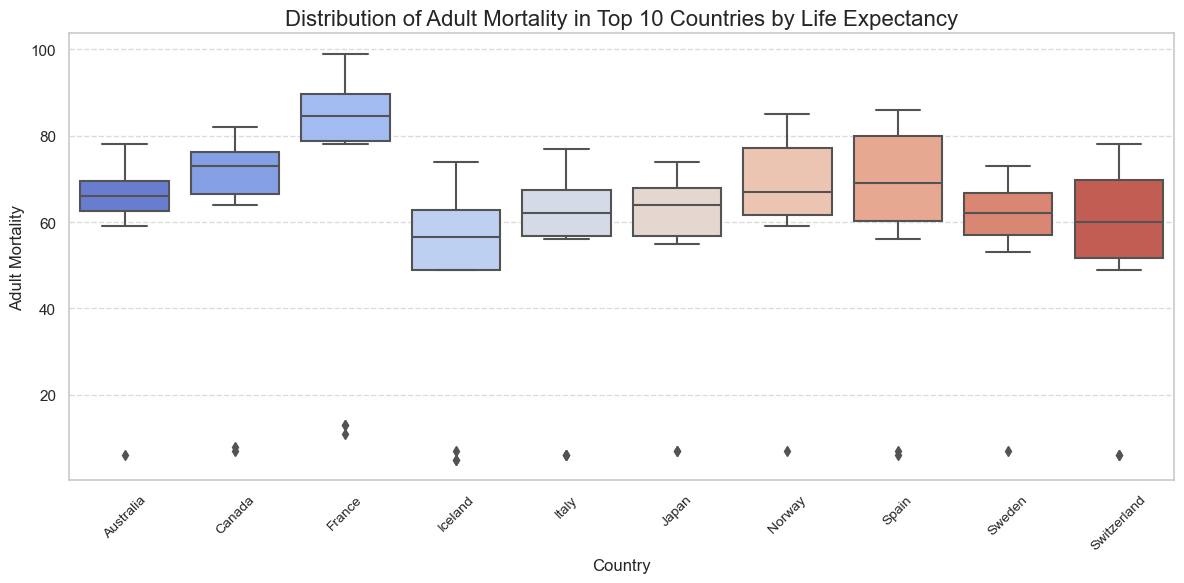

In [35]:
# Filter the data for the top 10 countries by average life expectancy
top_10_countries = df.groupby('Country').agg(Avg_Life_Exp=('Life Expectancy', 'mean')).nlargest(10, 'Avg_Life_Exp').index
boxplot_data = df[df['Country'].isin(top_10_countries)][['Country', 'Adult Mortality']]

# Create a refined boxplot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")  # Switch to a clean, white theme
sns.boxplot(data=boxplot_data, x="Country", y="Adult Mortality", palette="coolwarm")

# Enhance aesthetics
plt.title("Distribution of Adult Mortality in Top 10 Countries by Life Expectancy", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Adult Mortality", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

### **Distribution of Adult Mortality in Top 10 Countries by Life Expectancy**

**Objective**:  
This visualization highlights the distribution of adult mortality rates in the top 10 countries with the highest average life expectancy. It aims to reveal patterns, spread, and outliers in adult mortality rates for countries that consistently rank high in life expectancy.

---

#### **Key Insights**:
- **Consistency in Mortality Rates**:  
  Most top-ranking countries exhibit a low and consistent range of adult mortality, reflecting robust healthcare systems and higher living standards.
  
- **Outliers**:  
  Some countries show occasional spikes or broader distributions in adult mortality, which may indicate specific challenges (e.g., access to healthcare or aging populations).

- **Global Patterns**:  
  The visualization underscores the correlation between high life expectancy and low, stable adult mortality rates.

---

#### **Interpretation**:
- **Narrow Boxplots**:  
  Countries with narrow boxplots demonstrate less variability, suggesting consistently low adult mortality across the population.
  
- **Wide Boxplots**:  
  Countries with wider boxplots or outliers may face disparities in healthcare quality or accessibility, despite high life expectancy.

---

#### **Why This Visualization Matters**:
This analysis provides actionable insights for researchers and policymakers by:
1. Identifying countries with exceptional performance in reducing adult mortality.
2. Highlighting areas where improvements are needed, even among top-ranking nations.
3. Encouraging further exploration into the factors influencing mortality variability.

# Machine Learning Section
## Modelling a Random Forest Regressor
### We want to predict a given country's life expectancy using the model.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
print(df.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'percentage expenditure', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Diphtheria ', ' HIV/AIDS', 'GDP',
       ' thinness  1-19 years', ' thinness 5-9 years', 'Schooling', 'Row_ID'],
      dtype='object')


In [41]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

# Connect to SQLite database
conn = sqlite3.connect("world_life_expectancy.db")

# Load data from SQLite database
query = "SELECT * FROM world_life_expectancy"
df = pd.read_sql_query(query, conn)

# Rename columns for consistency
df.rename(columns={
    'Life expectancy ': 'Life Expectancy',
    ' BMI ': 'BMI',
    ' thinness  1-19 years': 'Thinness 1-19 years',
    ' thinness 5-9 years': 'Thinness 5-9 years',
    'Diphtheria ': 'Diphtheria',
    'Measles ': 'Measles'
}, inplace=True)

# Verify columns
print("Updated Column Names:", df.columns)

# Select relevant features and target
features = ['Status', 'GDP', 'BMI', 'Schooling']
target = 'Life Expectancy'

# Encode categorical variables
df['Status'] = df['Status'].map({'Developed': 1, 'Developing': 0})  # Convert 'Status' to numeric

# Check for missing values in relevant columns
print("Missing Values by Column:")
print(df[features + [target]].isnull().sum())

# Drop rows with missing values in relevant columns
data = df.dropna(subset=features + [target])

# Define features (X) and target (y)
X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 2000),
    'max_depth': randint(3, 100),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 50),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'max_samples': [0.5, 0.75, 1.0],  # Only applies when bootstrap=True
    'criterion': ['squared_error', 'absolute_error']
}

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Output best parameters
print(f'Best Hyper-Parameters for RF: {random_search.best_params_}')

Updated Column Names: Index(['Country', 'Year', 'Status', 'Life Expectancy', 'Adult Mortality',
       'infant deaths', 'percentage expenditure', 'Measles', 'BMI',
       'under-five deaths ', 'Polio', 'Diphtheria', ' HIV/AIDS', 'GDP',
       'Thinness 1-19 years', 'Thinness 5-9 years', 'Schooling', 'Row_ID'],
      dtype='object')
Missing Values by Column:
Status             8
GDP                0
BMI                0
Schooling          0
Life Expectancy    2
dtype: int64
Best Hyper-Parameters for RF: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 49, 'max_features': 'log2', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1291}


Best Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 49, 'max_features': 'log2', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1291}
Root Mean Square Error (RMSE): 4.895941902870353
R² Score: 0.7622485838778843


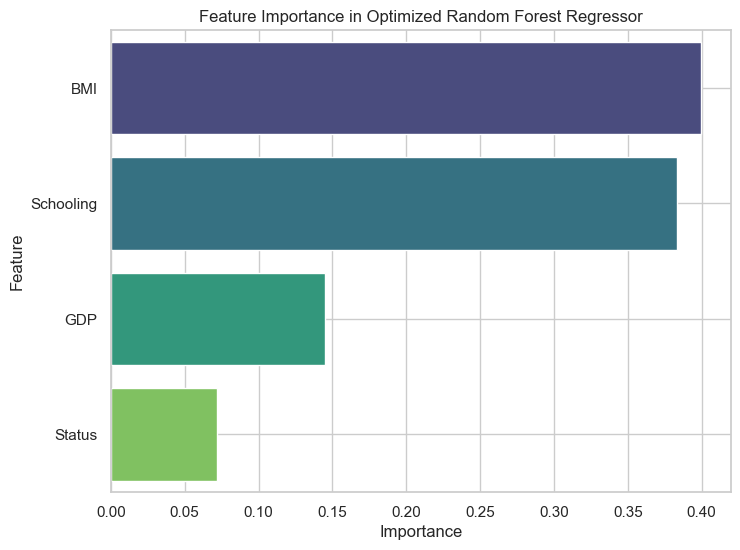

In [42]:
# Best model
best_rf_model = random_search.best_estimator_

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Feature importance
importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance in Optimized Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


# Model Optimization and Results

## Final Model Performance

**Best Hyperparameters:**
- `bootstrap`: **True** 
- `criterion`: **Squared Error** 
- `max_depth`: **49** 
- `max_features`: **Log2** 
- `max_samples`: **1.0** (uses all samples with replacement) 
- `min_samples_leaf`: **1** 
- `min_samples_split`: **6** 
- `n_estimators`: **1291**

**Evaluation Metrics:**
- **Root Mean Square Error (RMSE)**: **4.90** (lower is better) 
- **R² Score**: **0.76** (closer to 1 indicates a better fit)

---

## Insights
1. **RMSE Improvement**:
   - The RMSE has decreased, indicating the model's predictions are closer to actual values.

2. **R² Score Improvement**:
   - The R² score of 0.76 suggests that the model explains **76% of the variance** in life expectancy.

---

## Next Steps
1. **Feature Analysis**:
   - Use the feature importance plot to understand which features most influence the predictions.

2. **Residual Analysis**:
   - Examine residuals to ensure no patterns are left unexplained by the model.

3. **Validation**:
   - Test the model on an unseen dataset (if available) to confirm generalization.

4. **Further Optimization**:
   - Explore adding new features, interaction terms, or external data to improve predictive power.
   - Experiment with alternative models such as **Gradient Boosting** or **XGBoost**.

---